In [1]:
import numpy as np

from pathlib import Path
import logging

import matplotlib.pyplot as plt

In [2]:
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [3]:
%autoreload 2
from src.MapData import MapData

In [4]:
map_data = MapData()
map_data.get_metadata()
map_data.get_map_dimensions()
map_data.load_wavelenths()

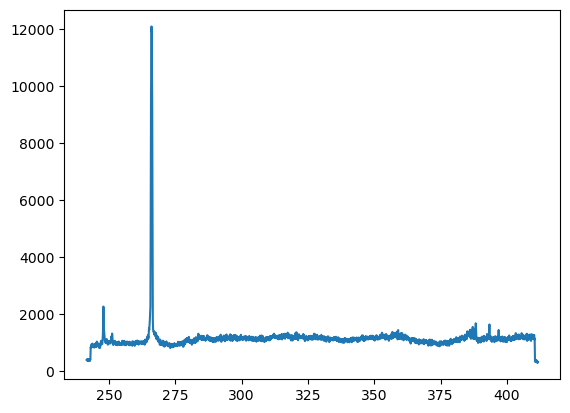

In [9]:
map_data.plot_random_spectrum()

In [10]:
map_data.load_all_data()

In [12]:
full_emissivities = map_data.spectra.sum(axis=1)

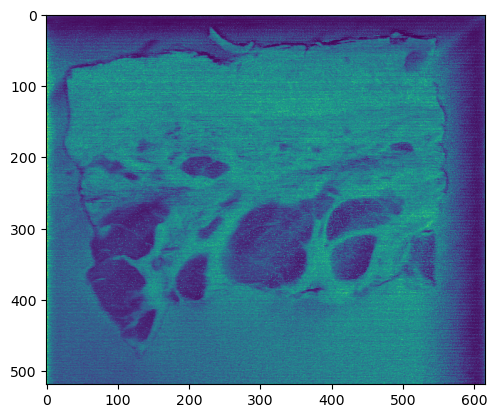

In [18]:
full_emissivities = full_emissivities.reshape(map_data.map_dimensions[::-1])
full_emissivities[::2,:] = full_emissivities[::2,::-1]

plt.imshow(full_emissivities)